In [96]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time

from keras.applications import vgg16
from keras import backend as K

In [97]:
ti = 'person.jpg'
s_name = 'starry'
si = s_name + '.jpg'

In [98]:
import os
base_image_path = os.path.join('datasets', ti)
style_image_path = os.path.join('datasets', si)
result_prefix = os.path.join('generated', s_name)
iterations = 20

total_variation_weight = 1.
style_weight = 250.
content_weight = 1.

width, height = load_img(base_image_path).size
img_nrows = 512
img_ncols = int(width * img_nrows / height)

In [99]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = vgg16.preprocess_input(img)
    return img

In [100]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [101]:
base_image = K.variable(preprocess_image(base_image_path))
style_image = K.variable(preprocess_image(style_image_path))

In [102]:
if K.image_data_format() == 'channel_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [103]:
input_tensor = K.concatenate(
    [
        base_image,
        style_image,
        combination_image
    ], axis = 0
)

In [104]:
model = vgg16.VGG16(
    input_tensor = input_tensor,
    weights = 'imagenet',
    include_top = False
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [105]:
output_dict = dict(
    [ (layer.name, layer.output) for layer in model.layers]
)

In [106]:
# Loss

In [107]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [108]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [109]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [110]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [111]:
# content loss
loss = K.variable(0.0)
layer_features = output_dict['block3_conv3']
base_image_features = layer_features[0, :, :, :]
combination_image_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features, combination_image_features)

# style loss
feature_layers = ['block1_conv2', 
                  'block2_conv2',
                  'block3_conv3', 
                  'block4_conv3']
for layer_name in feature_layers:
    layer_features = output_dict[layer_name]
    style_image_features = layer_features[1, :, :, :]
    combination_image_features = layer_features[2, :, :, :]
    sl = style_loss(style_image_features, combination_image_features)
    loss += (style_weight / len(feature_layers)) * sl

In [112]:
grads = K.gradients(loss, combination_image)

In [113]:
outputs = [loss]

if isinstance(grads, (list, tuple)):
    outputs += grads
else :
    outputs.append(grads)
    
f_outputs = K.function([combination_image], outputs)

In [114]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [115]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [116]:
x = preprocess_image(base_image_path)

In [117]:
import matplotlib.pyplot as plt

Start of iteration 0
Current loss value: 854538800000.0
Iteration 0 completed in 6s


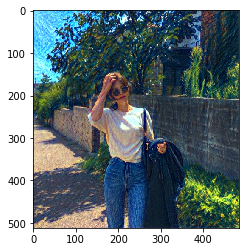

Start of iteration 1
Current loss value: 480636200000.0
Iteration 1 completed in 4s


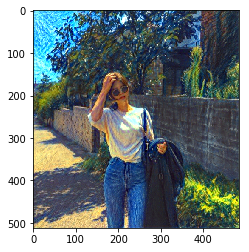

Start of iteration 2
Current loss value: 400768960000.0
Iteration 2 completed in 4s


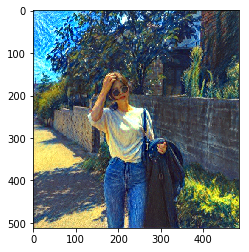

Start of iteration 3
Current loss value: 373541370000.0
Iteration 3 completed in 4s


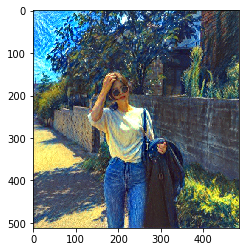

Start of iteration 4
Current loss value: 360011730000.0
Iteration 4 completed in 4s


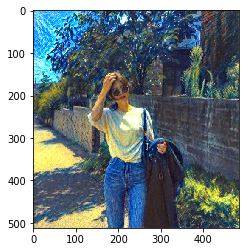

Start of iteration 5
Current loss value: 350984900000.0
Iteration 5 completed in 4s


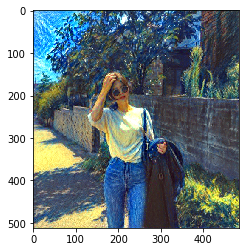

Start of iteration 6
Current loss value: 345736770000.0
Iteration 6 completed in 4s


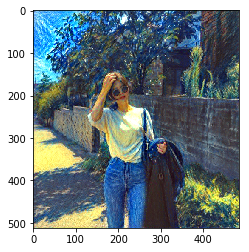

Start of iteration 7
Current loss value: 341568420000.0
Iteration 7 completed in 5s


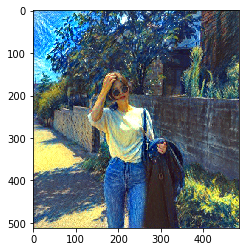

Start of iteration 8
Current loss value: 338581850000.0
Iteration 8 completed in 5s


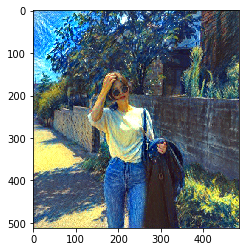

Start of iteration 9
Current loss value: 336013720000.0
Iteration 9 completed in 5s


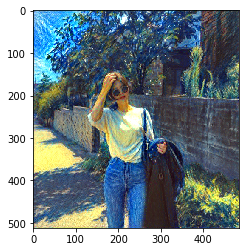

Start of iteration 10
Current loss value: 333910300000.0
Iteration 10 completed in 5s


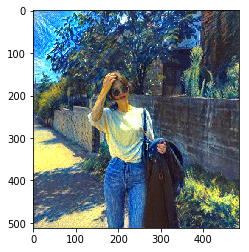

Start of iteration 11
Current loss value: 332105350000.0
Iteration 11 completed in 4s


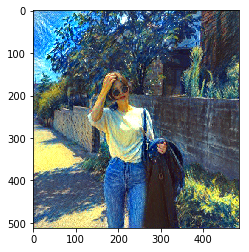

Start of iteration 12
Current loss value: 330627300000.0
Iteration 12 completed in 4s


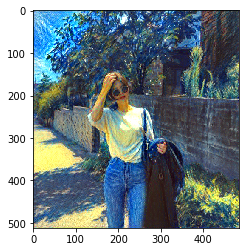

Start of iteration 13
Current loss value: 329294050000.0
Iteration 13 completed in 4s


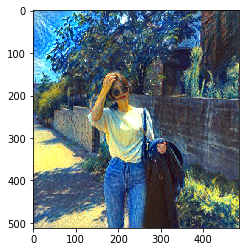

Start of iteration 14
Current loss value: 328146030000.0
Iteration 14 completed in 5s


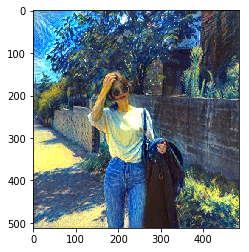

Start of iteration 15
Current loss value: 327116850000.0
Iteration 15 completed in 4s


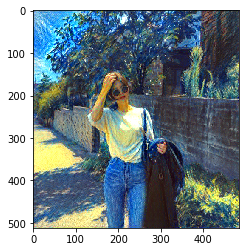

Start of iteration 16
Current loss value: 326256300000.0
Iteration 16 completed in 5s


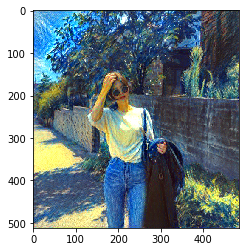

Start of iteration 17
Current loss value: 325478480000.0
Iteration 17 completed in 4s


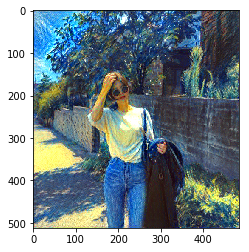

Start of iteration 18
Current loss value: 324759000000.0
Iteration 18 completed in 4s


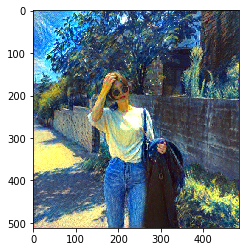

Start of iteration 19
Current loss value: 324111960000.0
Iteration 19 completed in 4s


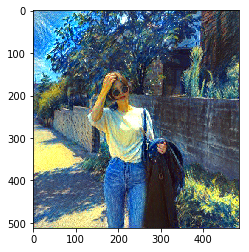

In [118]:
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
#     print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    plt.imshow(img)
    plt.show()